# Trade History Analysis

This notebook analyzes the trade history logged in `data/trade_history.csv`.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set style
plt.style.use('bmh')
sns.set_theme(style="darkgrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## 1. Load Data

In [6]:
try:
    df = pd.read_csv('../data/trade_history.csv')
    
    # Convert Timestamp to datetime
    df['Timestamp'] = pd.to_datetime(df['Timestamp'],format='mixed')
    
    # Sort by time
    df = df.sort_values('Timestamp')
    
    print(f"Loaded {len(df)} records.")
    display(df.head())
except FileNotFoundError:
    print("Error: data/trade_history.csv not found.")
    df = pd.DataFrame()

Loaded 32 records.


,Timestamp,Ticket,Symbol,Action,Volume,Price,SL,TP,Profit,Swap,Commission,Margin_Used,Balance,Equity,Comment
0,2026-02-16 21:38:05,43602296,AUDUSD,CLOSE_SHORT,0.14,0.70764,0.0,0.0,-4.34,0.0,0.0,0.0,995.66,995.66,NaN
1,2026-02-16 21:38:05,43602297,BTCUSD,CLOSE_LONG,0.10,68037.11000,0.0,0.0,38.29,0.0,0.0,0.0,1033.95,1033.95,NaN
2,2026-02-16 21:38:06,43602298,GER40ft,CLOSE_SHORT,0.10,24882.80000,0.0,0.0,-0.30,0.0,0.0,0.0,1033.65,1033.65,NaN
3,2026-02-16 21:38:06,43602299,BTCUSD,OPEN_LONG,0.15,68054.13000,0.0,0.0,0.00,0.0,0.0,0.0,1033.65,1033.65,EMAX
4,2026-02-16 21:38:06,43602300,BTCUSD,CLOSE_LONG,0.15,68037.11000,0.0,0.0,-2.55,0.0,0.0,0.0,1031.10,1031.10,NaN


## 2. Filter Closed Trades
We calculate performance based on CLOSED trades only.

In [7]:
if not df.empty:
    # Filter for Close actions
    # Actions are usually 'CLOSE_LONG' or 'CLOSE_SHORT'
    closed_trades = df[df['Action'].str.startswith('CLOSE')].copy()
    
    # Calculate Net Profit (including swap and commission if available)
    # Note: CSV columns are Profit, Swap, Commission
    closed_trades['Net_Profit'] = closed_trades['Profit'] + closed_trades['Swap'] + closed_trades['Commission']
    
    print(f"Found {len(closed_trades)} closed trades.")
    display(closed_trades[['Timestamp', 'Symbol', 'Action', 'Volume', 'Net_Profit']].tail())

Found 18 closed trades.


,Timestamp,Symbol,Action,Volume,Net_Profit
24,2026-02-17 20:00:02,PLTR,CLOSE_SHORT,76.70,-9.97
25,2026-02-17 20:14:21,BTCUSD,CLOSE_SHORT,0.15,214.19
27,2026-02-17 20:22:40,BTCUSD,CLOSE_LONG,0.15,42.73
29,2026-02-17 20:37:05,USDPLN,CLOSE_SHORT,0.03,2.96
30,2026-02-17 22:07:30,BTCUSD,CLOSE_LONG,0.15,-10.01


## 3. Performance Metrics

In [8]:
if not df.empty and not closed_trades.empty:
    total_pnl = closed_trades['Net_Profit'].sum()
    total_trades = len(closed_trades)
    
    wins = closed_trades[closed_trades['Net_Profit'] > 0]
    losses = closed_trades[closed_trades['Net_Profit'] <= 0]
    
    win_rate = len(wins) / total_trades * 100
    
    avg_win = wins['Net_Profit'].mean() if not wins.empty else 0
    avg_loss = losses['Net_Profit'].mean() if not losses.empty else 0
    
    profit_factor = abs(wins['Net_Profit'].sum() / losses['Net_Profit'].sum()) if not losses.empty and losses['Net_Profit'].sum() != 0 else float('inf')
    
    print("="*40)
    print(f"PERFORMANCE SUMMARY")
    print("="*40)
    print(f"Total Net PnL:    ${total_pnl:.2f}")
    print(f"Total Trades:     {total_trades}")
    print(f"Win Rate:         {win_rate:.1f}%")
    print(f"Profit Factor:    {profit_factor:.2f}")
    print(f"Avg Win:          ${avg_win:.2f}")
    print(f"Avg Loss:         ${avg_loss:.2f}")
    print("="*40)

PERFORMANCE SUMMARY
Total Net PnL:    $285.47
Total Trades:     18
Win Rate:         27.8%
Profit Factor:    4.55
Avg Win:          $73.16
Avg Loss:         $-6.18


## 4. Equity Curve

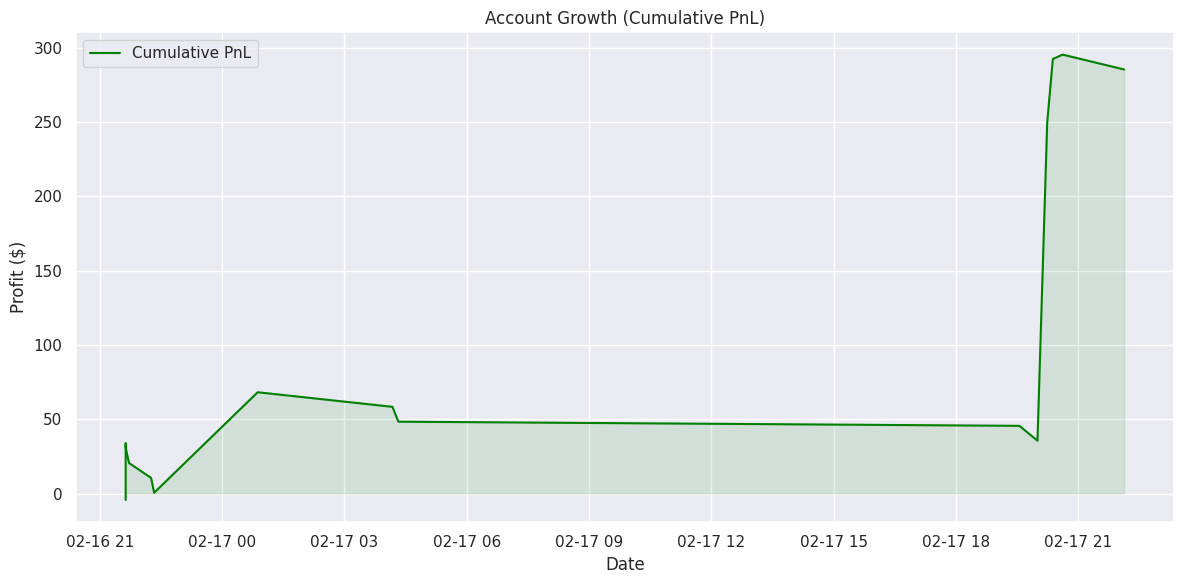

In [9]:
if not df.empty and not closed_trades.empty:
    closed_trades['Cumulative_PnL'] = closed_trades['Net_Profit'].cumsum()
    
    plt.figure(figsize=(12, 6))
    plt.plot(closed_trades['Timestamp'], closed_trades['Cumulative_PnL'], label='Cumulative PnL', color='green')
    plt.fill_between(closed_trades['Timestamp'], closed_trades['Cumulative_PnL'], alpha=0.1, color='green')
    plt.title('Account Growth (Cumulative PnL)')
    plt.xlabel('Date')
    plt.ylabel('Profit ($)')
    plt.legend()
    plt.tight_layout()
    plt.show()

## 5. Performance by Symbol

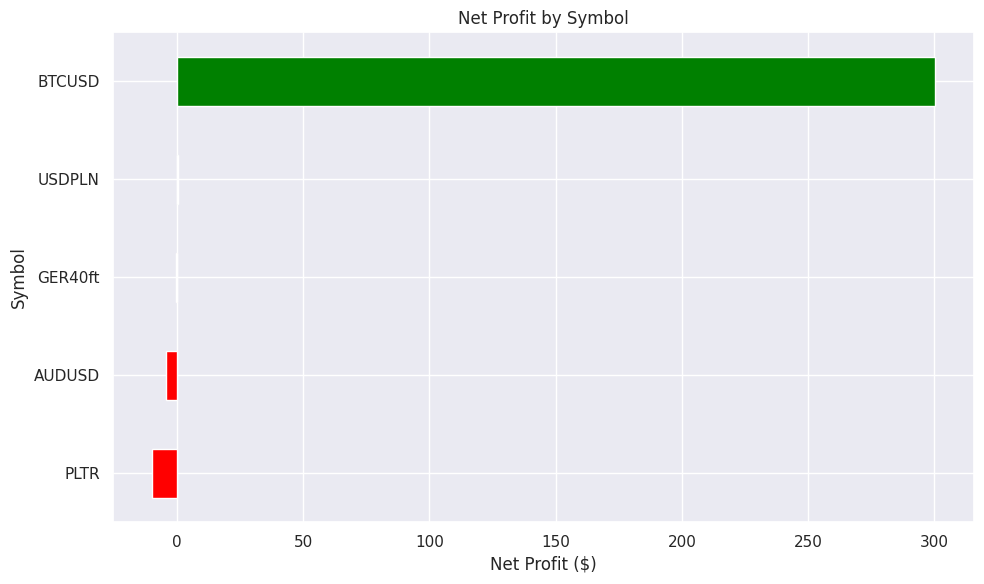

,Trades,PnL,Win_Rate
Symbol,,,
BTCUSD,11,300.28,36.363636
USDPLN,2,0.16,50.000000
GER40ft,3,-0.66,0.000000
AUDUSD,1,-4.34,0.000000
PLTR,1,-9.97,0.000000


In [10]:
if not df.empty and not closed_trades.empty:
    by_symbol = closed_trades.groupby('Symbol')['Net_Profit'].sum().sort_values()
    
    plt.figure(figsize=(10, 6))
    by_symbol.plot(kind='barh', color=by_symbol.apply(lambda x: 'green' if x > 0 else 'red'))
    plt.title('Net Profit by Symbol')
    plt.xlabel('Net Profit ($)')
    plt.tight_layout()
    plt.show()
    
    display(closed_trades.groupby('Symbol').agg(
        Trades=('Ticket', 'count'),
        PnL=('Net_Profit', 'sum'),
        Win_Rate=('Net_Profit', lambda x: (x > 0).mean() * 100)
    ).sort_values('PnL', ascending=False))

## 6. Trade Duration Analysis

In [11]:
# To calculate duration, we need to match Opens with Closes using Ticket ID
# This assumes the CSV contains both OPEN and CLOSE for the same ticket.

if not df.empty:
    opens = df[df['Action'].str.startswith('OPEN')].set_index('Ticket')
    closes = df[df['Action'].str.startswith('CLOSE')].set_index('Ticket')
    
    # Join on Ticket
    trades = closes.join(opens, lsuffix='_Close', rsuffix='_Open', how='inner')
    
    if not trades.empty:
        trades['Duration'] = trades['Timestamp_Close'] - trades['Timestamp_Open']
        trades['Duration_Minutes'] = trades['Duration'].dt.total_seconds() / 60
        
        print(f"Average Trade Duration: {trades['Duration_Minutes'].mean():.1f} minutes")
        
        plt.figure(figsize=(10, 5))
        plt.hist(trades['Duration_Minutes'], bins=20, color='skyblue', edgecolor='black')
        plt.title('Trade Duration Distribution')
        plt.xlabel('Minutes')
        plt.ylabel('Frequency')
        plt.show()
    else:
        print("Not enough paired Open/Close records to calculate duration.")

Not enough paired Open/Close records to calculate duration.
